## Recommender system
In this notebook, I build a collaborative-filtering recommendation model based on a dataset of transactions, and then use this model to recommend new products to customers.

1. Transactions dataset
2. Matrix factorization model
3. Making recommendations

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import plot_common_elements, preprocess_and_split, get_mappings, mf_model, train_model, recommend
sns.set()

### 1. Transactions dataset

In [ ]:
transactions_location = 'transactions_sample.csv'transactions = pd.read_csv(transactions_location)
transactions.head(3)

,customer_uuid,product_uuid,product_category
0,84941cf9-d19d-4c1d-b180-845e36a931b0,03058102-487d-4424-b984-23453dda75a2,tea -- fruit
1,3ad4d182-e1d6-4052-8a65-6b7cbe817027,03058102-487d-4424-b984-23453dda75a2,tea -- fruit
2,b1a61ad5-7569-424f-83ff-d9305acd3a21,03058102-487d-4424-b984-23453dda75a2,tea -- fruit


Some basic stats on the transactions dataset:

In [ ]:
print(f'Total number of transactions: {len(transactions)}')
print(f'Number of unique customers: {len(transactions["customer_uuid"].unique())}')
print(f'Number of unique products: {len(transactions["product_uuid"].unique())}')
print(f'Number of unique product categories: {len(transactions["product_category"].unique())}')

Total number of transactions: 102102
Number of unique customers: 4760
Number of unique products: 3188
Number of unique product categories: 574


We look at some of the most frequent elements in the dataset:

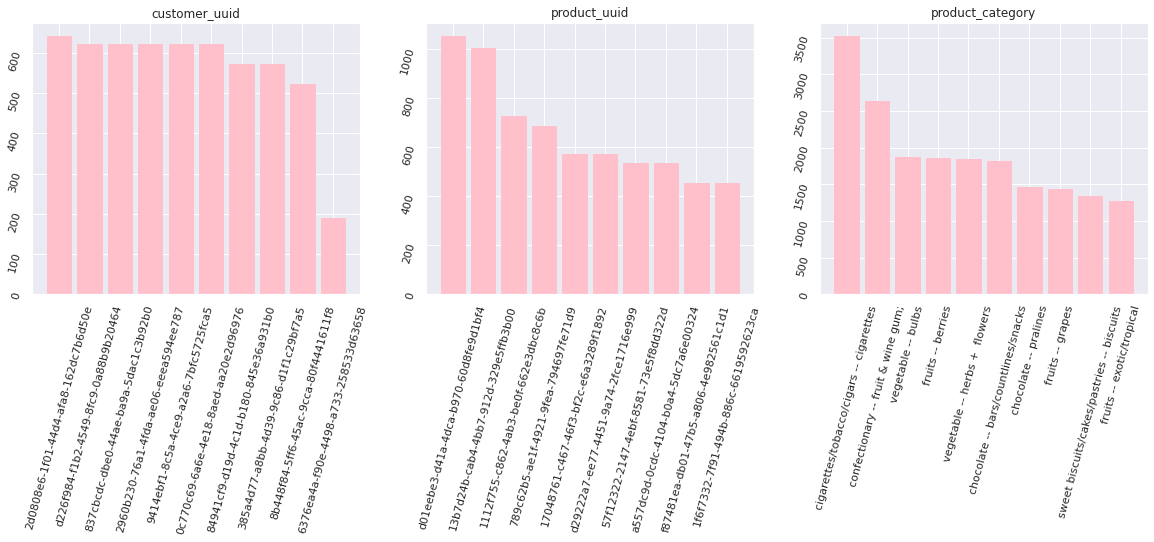

In [ ]:
plot_common_elements(df=transactions, amount=10, ascending=False)

The user with the id "2d0808e6-1f01-44d4-afa8-162dc7b6d50e" has bought the most products, namely around 650. We also see that the top nine customers buy a lot more than the rest of the customers. <br>

The product which was bought most often was bought over 1000 times, and the most popular type of products are cigarettes and wine gums. <br><br>

Similarly, we can look at some less frequent elements. For example, how many customers and products occur only once in the dataset?

In [ ]:
print(f'Number of customers that only bought one product: {len(transactions[transactions.groupby("customer_uuid").customer_uuid.transform(len) == 1])}')
print(f'Number of products that were only bought once: {len(transactions[transactions.groupby("product_uuid").customer_uuid.transform(len) == 1])}')

Number of customers that only bought one product: 238
Number of products that were only bought once: 524


In collaborative filtering recommendation, when we have too few samples of users or products we are facing the "cold start" problem. There is not yet enough data to base new predictions on. It might therefore be helpful to remove some of low-frequent customers and products. We still have many datapoints for most customers and products, so we should still be able to make recommendations based on those.

Let's take a look at two individual customers and their preferences. To make it a bit easier we can call them Hertha and John:

In [ ]:
hertha = transactions[transactions['customer_uuid']=='f0e551d9-186a-42d9-bfdd-6ea6e17966f6']
john = transactions[transactions['customer_uuid']=='72fe038a-b598-4ec8-a26d-d0ed3b1af3c6']

In [ ]:
hertha['product_category'].value_counts()[:10]

cigarettes/tobacco/cigars -- cigarettes           24
confectionary -- fruit & wine gum;                 9
cigarettes/tobacco/cigars -- tobacco loose/ryo     6
sweet biscuits/cakes/pastries -- biscuits          5
carbonated soft drinks -- cola carbonated          5
chocolate -- tablets                               4
carbonated soft drinks -- tonic water              3
ice cream -- impulse to resell                     3
power drinks -- energy drinks                      3
cigarettes/tobacco/cigars -- cigarillos            3
Name: product_category, dtype: int64

In [ ]:
john['product_category'].value_counts()[:10]

vegetable -- herbs +  flowers        6
fruits -- berries                    5
vegetable -- bulbs                   4
vegetable -- peppers                 3
vegetable -- salads                  3
fruits -- pears                      2
fresh pastry -- small desserts       2
fresh bread -- baguette and baton    2
vegetable -- potatoes                2
butter -- butter pure unsalted       1
Name: product_category, dtype: int64

Based on their most bought products, we can see a difference in John's and Hertha's preferences. Without judging, Hertha seems to have a preference for products that some would call more unhealthy: cigarettes, sweet snacks and drinks, while John has a preference for buying vegetables and fruits.

#### Prepare data for use in training
The preprocssing consists of
- converting customer ids and product ids to integers
- removing customers and products that occur infrequently in the data
- shuffling data
- splitting into train and test data

In [ ]:
train, test = preprocess_and_split(data=transactions, test_size=0.2, minimum_customer_freq=8, minimum_product_freq=8)

In [ ]:
train.shape, test.shape

((72190, 6), (18048, 6))

### 2. Matrix factorization model
The model is a simple matrix factorization model built with Keras layers. It creates embeddings for customers and for products, the size of which is defined by the chosen number of latent factors. <br>
The predictions are made by taking the dot product of the two flattened embeddings and the loss is the mean squared error. 


In [ ]:
n_users = len(transactions['customer_uuid'].unique())
n_items = len(transactions['product_uuid'].unique())

In [ ]:
N_FACTORS = 15
model = mf_model(n_users=n_users, n_items=n_items, n_latent_factors=N_FACTORS)

In [ ]:
history = train_model(model=model, train_data=train, epochs=10)

Epoch 1/10
2256/2256 [==============================] - 14s 6ms/step - loss: 0.7746 - mse: 0.7746
Epoch 2/10
2256/2256 [==============================] - 13s 6ms/step - loss: 0.0768 - mse: 0.0768
Epoch 3/10
2256/2256 [==============================] - 13s 6ms/step - loss: 0.0050 - mse: 0.0050
Epoch 4/10
2256/2256 [==============================] - 13s 6ms/step - loss: 7.6879e-04 - mse: 7.6879e-04
Epoch 5/10
2256/2256 [==============================] - 14s 6ms/step - loss: 8.9495e-04 - mse: 8.9495e-04
Epoch 6/10
2256/2256 [==============================] - 13s 6ms/step - loss: 9.1028e-04 - mse: 9.1028e-04
Epoch 7/10
2256/2256 [==============================] - 13s 6ms/step - loss: 8.9276e-04 - mse: 8.9276e-04
Epoch 8/10
2256/2256 [==============================] - 13s 6ms/step - loss: 8.7639e-04 - mse: 8.7639e-04
Epoch 9/10
2256/2256 [==============================] - 13s 6ms/step - loss: 8.5705e-04 - mse: 8.5705e-04
Epoch 10/10
2256/2256 [==============================] - 13s 6ms/step 

Plot of the training loss

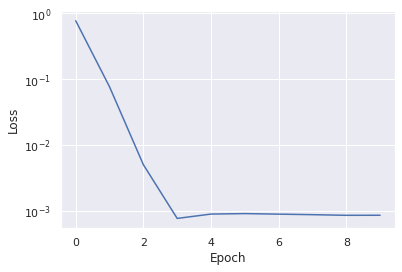

In [ ]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Loss");

In [ ]:
results = model.evaluate((test.user_id, test.item_id), test.label, batch_size=1, return_dict=True)

18048/18048 [==============================] - 49s 3ms/step - loss: 9.2026e-04 - mse: 9.2026e-04


In [ ]:
print(f"train mse: {round(8.8423e-04, 6)}")
print(f'test mse: {round(results["loss"],6)}')

train mse: 0.000884
test mse: 0.00092


### 3. Making recommendations
To recommend products to a user, we take the embedding of the user and do the dot product with all the product embeddings. We then return the products with the largest corresponding values.

In [ ]:
item_embeddings = model.get_layer(name='ItemEmbedding').get_weights()[0]
user_embeddings = model.get_layer(name='UserEmbedding').get_weights()[0]

# I also need the mappings between the original ids and the integers
user_int_to_uuid, user_uuid_to_int, product_int_to_uuid, product_uuid_to_int, product_uuid_to_category = get_mappings(transactions)

We can try recommending five products to Hertha and John who we saw in the data exploration section:

In [ ]:
hertha_id = 'f0e551d9-186a-42d9-bfdd-6ea6e17966f6'
herthas_recommendations = recommend(customer_id=hertha_id,
                                    item_embeddings=item_embeddings,
                                    user_embeddings=user_embeddings,
                                    number_of_products=5,
                                    user_uuid_to_int=user_uuid_to_int,
                                    product_int_to_uuid=product_int_to_uuid)
print('Recommendations for Hertha:')
herthas_recommendations

Recommendations for Hertha:


['21fa1fee-e860-4f43-af98-01c57cf878d7',
 '4d408d6e-4bce-4a7d-92bf-799e32c5f888',
 'da45aa9e-6635-401f-8c56-b8131710b7a7',
 '2e52d6ad-e75c-43c9-b8ba-34705d9e3047',
 '7ad9b81b-4685-4e0b-b105-52ee64f832ef']

Let's look at the product categories of the recommended products to check whether they make sense for Hertha:

In [ ]:
[product_uuid_to_category[product] for product in herthas_recommendations]

['confectionary -- lollies/hard candies',
 'confectionary -- fruit & wine gum;',
 'coffee cream/milk powder -- coffee cream',
 'eggs -- chicken deep litter indoor hou',
 'stocks/savouring -- stock granulated']

Let's do the same for John

In [ ]:
john_id = '72fe038a-b598-4ec8-a26d-d0ed3b1af3c6'
johns_recommendations = recommend(customer_id=john_id,
                                  item_embeddings=item_embeddings,
                                  user_embeddings=user_embeddings,
                                  number_of_products=5,
                                  user_uuid_to_int=user_uuid_to_int,
                                  product_int_to_uuid=product_int_to_uuid)
[product_uuid_to_category[product] for product in johns_recommendations]

['vegetable -- herbs +  flowers',
 'eggs -- chicken deep litter indoor hou',
 'seasonings -- world seasoning',
 'juices/still drinks -- 100% direct/not from concentr.',
 'semi soft/semi hard -- gouda']

## Functions